# Import needed libraries

In [1]:
!pip install gurobipy
!pip install pyqubo
!pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys
import time
from collections import defaultdict
import re # to extract numbers from strings

import numpy as np
from numpy import linalg as la
import networkx as nx

# Gurobi libraries
import gurobipy as gp
from gurobipy import GRB

# DWave libraries
import dwave.cloud as dc
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from dimod import BinaryQuadraticModel
import neal

# Library to prepare QUBO formulation
from pyqubo import Array, Binary, Constraint, SubH

# Connect to DWave and choose solver

In [3]:
token = '' # put your personal token here
endpoint = 'https://cloud.dwavesys.com/sapi'

In [4]:
# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
}

# Connect to the D-Wave system
client = dc.Client.from_config(**config)

# Print the available samplers and their names
for solver in client.get_solvers():
    print("Solver Name:", solver.id)

Solver Name: hybrid_binary_quadratic_model_version2
Solver Name: hybrid_discrete_quadratic_model_version1
Solver Name: hybrid_constrained_quadratic_model_version1
Solver Name: Advantage2_prototype1.1
Solver Name: Advantage_system6.2
Solver Name: Advantage_system4.1


In [5]:
# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
    'solver': 'Advantage_system6.2'  # Specify the DWave solver name we want to use
}

# choose the sampler
# Simulated Annealing
sampler = neal.SimulatedAnnealingSampler()
# DWave sampler
# sampler = DWaveSampler(**config)
# sampler = EmbeddingComposite(sampler) # DWave built-in embedding strategy

# Generate a random graph

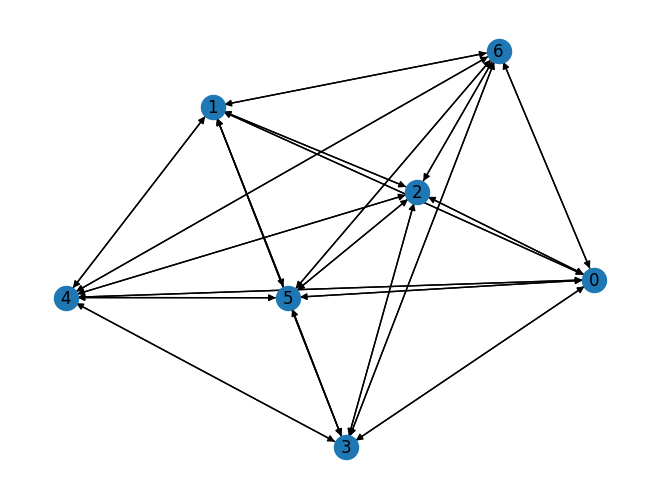

In [6]:
# number of nodes
n = 7

# number of vehicles
k = 3

# generate random Adjacency matrix
E = np.random.randint(0, 10, size=(n, n))
# make it symmetrical (to avoid getting stuck in dead ends)
E = E + E.T
# take away the diagonal
E = E - np.diag(np.diag(E))

# generate graph from Adjacency matrix
G = nx.from_numpy_array(E, create_using=nx.DiGraph)

# fix depot node
depot = 0

# draw Graph using Fruchterman-Reingold force-directed algorithm
nx.draw(G, nx.spring_layout(G), with_labels=True)

# Useful functions

## check if feasible solution is an actual route

In [7]:
def is_valid_routing(edges, VERBOSE=False, formulation=1):

  # get starting edges of each route
  routes = []

  if formulation==1:
    for edge in edges:    # edge = (node i, node j)
      if edge[0]==0:
        routes.append([edge[0], edge[1]])

    # attempt to build the routes
    for i in range(len(routes)):
      # build route for i-th vehicle
      next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
      if next_nodes == []:
        pass
      else:
        next_node = next_nodes[0]
        routes[i].append(next_node)
        while (len(routes[i])<n) and (next_node!=0) and (next_nodes!=[]):
          next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
          if next_nodes != []:
            next_node = next_nodes[0]
            routes[i].append(next_node)

  elif formulation==2:
    for v in range(k):
      # take nodes visited by v-th vehicle
      nodes_vth_veich = sorted([edge for edge in edges if edge[0]==v], key=lambda x: x[2])    # edge = (vehicle, node, timestep)
      # check time consistency (one node per time step)
      time_steps = [node[2] for node in nodes_vth_veich]
      if time_steps != [i for i in range(n)]:
        if VERBOSE==True:
          print('Not a valid routing')
        return (False, routes)
      else:
        routes.append([node[1] for node in nodes_vth_veich])

  # check wether each node is visited
  for i in range(n):
    l = [route for route in routes if i in route]
    if l==[]:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  if VERBOSE==True:
    print('Valid routing. The routes are\n')
    for route in routes:
      print(route)

  return (True, routes)

## get visited edges from annealing sampling

In [8]:
# get edges
def get_edges_from_sample(sample, formulation=1):

  edges = []

  if formulation==1:
    for i in range(n):
      for j in range(n):
        if sample[f'x[{i}][{j}]']==1:
          edges.append((i, j))

  elif formulation==2:
    for v in range(k):
      for i in range(n):
        for j in range(n):
          if sample[f'x[{v}][{i}][{j}]']==1:
            edges.append((v, i, j))

  return edges

## Graver Augmentation

In [9]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
  return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
  for i, val in enumerate(iterable):  #[i = graver element, val=(obj, step_size)]
      if val[1] != 0:
          return i, val
  return i, val

In [10]:
# We can just have a single step move (works well with greedy approach)
def single_move(g, fun, x, x_lo = None, x_up = None):
  if x_lo is None:
      x_lo = np.zeros_like(x)
  if x_up is None:
      x_up = np.ones_like(x)

  alpha = 0

  if (x + g <= x_up).all() and (x + g >= x_lo).all():
      if fun(x + g) < fun(x):
          alpha = 1
  elif (x - g <= x_up).all() and (x - g >= x_lo).all():
      if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
          alpha = -1

  return (fun(x + alpha*g), alpha)

In [11]:
def augmentation(grav, func, x, x_lo = np.zeros(n*n), x_up = np.ones(n*n), VERBOSE = True, itermax = 1000):
  # Let's perform the augmentation and return the number of steps and the best solution
  # OPTION = 3 # Greedy augmentation, select using first found
  dist = 1
  gprev = None
  k = 1
  if VERBOSE:
      print("Initial point:", x)
      print("Objective function:",func(x))
  while dist != 0 and k < itermax:
    g1, (obj, dist) = greedy(single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
    x = x + grav[g1]*dist
    gprev = grav[g1]
    if VERBOSE:
        print("Iteration ", k)
        print('Graver element, (obj, alpha):', g1, (obj, dist))
        print("Augmentation direction:", gprev)
        print("Objective function:", func(x))
        print("Current point:", x)
        print("Are constraints satisfied?", const(x))
    else:
        if k%50 == 0:
            print(k)
            print(obj)
    k += 1
  return(k, obj, x)

In [12]:
def get_feasible(A, b, sampler, samples=1000, refine_almost_feasible=False):

  AA = np.dot(A.T, A)
  h = -2.0*np.dot(b.T, A)
  Q = AA + np.diag(h)
  offset = np.dot(b.T, b) + 0.0

  # Define Binary Quadratic Model
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)

  response = sampler.sample(bqm, num_reads=samples)

  # remove duplicates from the sample set
  response = response.aggregate()

  filter_idx = [i for i, e in enumerate(response.record.energy) if e == 0.0] # get only actual feasible solutions
  feas_sols = response.record.sample[filter_idx]

  # feas_sols contains the actual solutions of the QUBO problem,
  # namely those x such that Ax=0 (to get graver elems) and Ax=b (to get feasible solutions)
  # Usually, when solving for the graver elements it might happen that we also find several
  # low energy solutions y such that Ay ~ 0 but Ay!=0.
  # Instead of discarding such y's, it is convenient to combine them in order
  # to create new graver elements. That's what we do in the next lines of code

  if refine_almost_feasible==True:

    # get unfeasible solutions
    filter_idx = [i for i, e in enumerate(response.record.energy) if e != 0.0]
    sols = response.record.sample[filter_idx]
    # compute error matrix
    Error_matrix = np.dot(A, sols.T)

    # almost feasible solutions with gap-value of 1
    err_one_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==1]
    almost_feas_sols_1 = sols[err_one_sols]
    # create new feasible solutions
    feas_sols_1 = filter_sol_abs_error(almost_feas_sols_1, abs_error=1)
    # stack everything togheter
    if feas_sols_1.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_1])

    # almost feasible solutions with gap-value of 2
    err_two_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==2]
    almost_feas_sols_2 = sols[err_two_sols]
    # create new feasible solutions
    feas_sols_2 = filter_sol_abs_error(almost_feas_sols_2, abs_error=2)
    # stack everything togheter
    if feas_sols_2.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_2])

  # remove duplicate solutions
  feas_sols = np.unique(feas_sols, axis=0)
  return feas_sols

In [13]:
# this functions takes as input a set of almost feasible solutions
# and combines them to create new actual feasible solutions
def filter_sol_abs_error(sols, abs_error=1):

  plus_one_group = []
  minus_one_group = []
  for i in range(sols.shape[0]):
    if np.sum(np.dot(A, sols[i].T))==abs_error:
      plus_one_group.append(sols[i])
    elif np.sum(np.dot(A, sols[i].T))==-abs_error:
      minus_one_group.append(sols[i])

  plus_one_group = np.array(plus_one_group)
  minus_one_group = np.array(minus_one_group)

  new_sols = []

  for i in range(plus_one_group.shape[0]):
    for j in range(i, plus_one_group.shape[0]):
      curr_sol = plus_one_group[i] - plus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(minus_one_group.shape[0]):
    for j in range(i, minus_one_group.shape[0]):
      curr_sol = minus_one_group[i] - minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(plus_one_group.shape[0]):
    for j in range(minus_one_group.shape[0]):
      curr_sol = plus_one_group[i] + minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)

  new_sols = np.array(new_sols)
  return new_sols

In [14]:
def graver_multiseed_augmentation(feas_sols, graver_elems, const, f):

  if len(feas_sols)==0:
    print('No feasible solutions to augment')
    return

  init_obj = np.zeros((len(feas_sols)))
  iters_full = np.zeros((len(feas_sols)))
  final_obj_full = np.zeros((len(feas_sols)))
  times_full = np.zeros((len(feas_sols)))
  final_sols = np.zeros(shape=(len(feas_sols), feas_sols[0].shape[0]))

  for i, sol in enumerate(feas_sols):
    if not const(sol):
      print("Infeasible")
      pass
    init_obj[i] = f(sol)
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = graver_elems, func = f, x = sol,
                                   x_lo = np.zeros(feas_sols[0].shape[0]),
                                   x_up = np.ones(feas_sols[0].shape[0]),
                                   VERBOSE=False)
    times_full[i] = time.process_time() - start
    iters_full[i] = iter
    final_obj_full[i] = f_obj
    final_sols[i, :] = xf

  return (final_sols, final_obj_full)

# VRP with exactly k vehicles - First Formulation

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N(0)} x_{0j} = k \\
& \sum_{j \in N(0)} x_{j0} = k \\
& \sum_{j \in N(i)} x_{ij} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i \in N(j)} x_{ij} = 1 \quad \forall j=1, \dots, n-1 \\
& x_{ij} \in \{0, 1\} \quad \forall i,j=0, \dots, n-1
\end{alignat*}

## Gurobi

In [15]:
# Declare and initialize model
m = gp.Model('VRP')

Restricted license - for non-production use only - expires 2024-10-28


### Decision variables

In [16]:
# Create decision variables
x = m.addVars(n, n, vtype=GRB.BINARY, name="assign")

### Constraints

In [17]:
# take away diagonal variables
m.addConstrs((x[i, i] == 0 for i in range(n)))

# k vehicle departing from depot
m.addConstr(sum(x[0, j] for j in range(n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[j, 0] for j in range(n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[i, j] for i in range(n) if E[i, j]!=0) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[i, j] for j in range(n) if E[i, j]!=0) == 1 for i in range(1, n)), name='leave_node')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>}

### Objective function

In [18]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n)])

m.setObjective(obj, GRB.MINIMIZE)

### Optimize

In [19]:
# Save model for inspection
m.write('VRP.lp')

In [20]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 21 rows, 49 columns and 91 nonzeros
Model fingerprint: 0x2e59d435
Variable types: 0 continuous, 49 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 97.0000000
Presolve removed 7 rows and 7 columns
Presolve time: 0.00s
Presolved: 14 rows, 42 columns, 84 nonzeros
Variable types: 0 continuous, 42 integer (42 binary)

Root relaxation: objective 4.900000e+01, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      49.0000000

### Routes

In [21]:
# get non zero decision variables
routes = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(False, [[0, 1, 0], [0, 4, 0], [0, 5, 2, 0]])

## QUBO

### Formulation

\begin{align}
\min_{x_{ij} \in \{0,1\} \forall i,j} x^tQx
\end{align}
namely
\begin{align}
\min_{x_{ij} \in \{0,1\} \forall i,j} \sum_{i, j} c_{ij}x_{ij} + + \rho\left[\sum_{(i,j)\notin E}x_{ij} + \left(\sum_{j \in N(0)} x_{0j} - k\right)^2 + \left(\sum_{j \in N(0)} x_{j0} - k\right)^2 + \sum_{i}\left(\sum_{j \in N(i)} x_{ij} - 1\right)^2 + \sum_{j}\left(\sum_{i \in N(j)} x_{ij} - 1 \right)^2\right]
\end{align}

### QUBO matrix

In [22]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
b = np.array(m.getAttr("RHS", m.getConstrs()))
obj_coeffs = m.getAttr("Obj", m.getVars())
obj_coeffs = np.array(obj_coeffs).reshape((n,n))

# create QUBO variables
x = Array.create('x', shape=(n, n), vartype='BINARY')

# define objective function
obj = sum(obj_coeffs[i,j]*x[i,j] for i in range(n) for j in range(n))

# penalty factors for QUBO
# p = np.sum(obj_coeffs)+1
p = n*np.max(obj_coeffs)

In [23]:
# DOESN'T WORK. RUNTIME CRASHES (MEMORY ISSUES??)

# # build QUBO using Gurobi data
# constrs = np.dot(A.toarray(), x.reshape((n*n, 1))) - b
# Q = obj + p*np.dot(constrs.T, constrs)

# # also, penalize the usage of non-existing edges
# Q += p*(Constraint(sum([x[i, j] for i in range(n) for j in range(n) if E[i, j]==0]), label='non_existing_edges'))

In [24]:
# build QUBO by manually adding constraints
# add the objective
Q =  obj

# add the constraints
# penalize the usage of non-existing edges
Q += p*(Constraint(sum([x[i, j] for i in range(n) for j in range(n) if E[i, j]==0]), label='non_existing_edges'))

# k vehicles leaving the depot
Q += p*(Constraint((sum([x[0, j] for j in range(1, n) if E[0, j]!=0])-k)**2, label='leave_depot'))

# k vehicles returning to depot
Q += p*(Constraint((sum([x[j, 0] for j in range(1, n) if E[j, 0]!=0])-k)**2, label='return_depot'))

# only one edge coming out from each node
Q += p*sum([Constraint((sum([x[i, j] for j in range(1, n) if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in range(1, n)])

# only one edge entering each node
Q += p*sum([Constraint((sum([x[i, j] for i in range(1, n) if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in range(1, n)])

In [25]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('x[2][6]', 'x[2][6]'): -216.0,
 ('x[6][5]', 'x[6][1]'): 224.0,
 ('x[6][3]', 'x[2][3]'): 224.0,
 ('x[0][5]', 'x[0][3]'): 224.0,
 ('x[4][0]', 'x[3][0]'): 224.0,
 ('x[0][3]', 'x[0][2]'): 224.0,
 ('x[6][2]', 'x[3][2]'): 224.0,
 ('x[3][1]', 'x[3][1]'): -217.0,
 ('x[1][2]', 'x[1][2]'): -212.0,
 ('x[0][3]', 'x[0][3]'): -547.0,
 ('x[1][5]', 'x[1][3]'): 224.0,
 ('x[5][4]', 'x[3][4]'): 224.0,
 ('x[5][4]', 'x[5][2]'): 224.0,
 ('x[6][5]', 'x[6][5]'): -212.0,
 ('x[2][3]', 'x[2][1]'): 224.0,
 ('x[4][5]', 'x[4][5]'): -214.0,
 ('x[6][0]', 'x[2][0]'): 224.0,
 ('x[2][3]', 'x[2][3]'): -216.0,
 ('x[6][4]', 'x[6][3]'): 224.0,
 ('x[1][5]', 'x[1][4]'): 224.0,
 ('x[5][1]', 'x[3][1]'): 224.0,
 ('x[5][6]', 'x[5][4]'): 224.0,
 ('x[1][4]', 'x[1][4]'): -215.0,
 ('x[5][6]', 'x[3][6]'): 224.0,
 ('x[3][1]', 'x[2][1]'): 224.0,
 ('x[4][0]', 'x[4][0]'): -557.0,
 ('x[4][2]', 'x[4][1]'): 224.0,
 ('x[4][5]', 'x[1][5]'): 224.0,
 ('x[6][3]', 'x[1][3]'): 224.0,
 ('x[6][5]', 'x[3][5]'): 224.0,
 ('x[2][4]', 'x[1][4]'): 224.0,

### Solve QUBO

In [26]:
# solve via choosen sampler
sampleset = sampler.sample_qubo(Q, num_reads=1000)#, num_steps=1000)

# get num_reads solutions obtained
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual routes)
samples = [s for s in samples if is_valid_routing(get_edges_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'x[6][6]': 0, 'x[6][4]': 0, 'x[6][1]': 0, 'x[5][5]': 0, 'x[5][4]': 1, 'x[5][3]': 0, 'x[5][0]': 1, 'x[4][6]': 1, 'x[4][5]': 0, 'x[6][0]': 0, 'x[5][2]': 0, 'x[4][4]': 0, 'x[4][2]': 0, 'x[1][4]': 0, 'x[1][3]': 0, 'x[4][3]': 0, 'x[3][1]': 1, 'x[4][1]': 0, 'x[1][1]': 0, 'x[1][2]': 1, 'x[2][6]': 0, 'x[3][0]': 1, 'x[6][5]': 0, 'x[0][4]': 1, 'x[5][1]': 0, 'x[0][3]': 0, 'x[6][2]': 0, 'x[0][2]': 0, 'x[0][0]': 0, 'x[5][6]': 0, 'x[0][6]': 1, 'x[2][3]': 0, 'x[2][2]': 0, 'x[1][6]': 0, 'x[2][0]': 0, 'x[2][5]': 1, 'x[6][3]': 1, 'x[1][5]': 0, 'x[1][0]': 0, 'x[2][1]': 0, 'x[2][4]': 0, 'x[3][5]': 0, 'x[0][1]': 1, 'x[3][2]': 0, 'x[3][3]': 0, 'x[3][4]': 0, 'x[3][6]': 0, 'x[0][5]': 0, 'x[4][0]': 1} 
 90.0


In [27]:
# compute original objective function value in best_sample
x = np.zeros((n,n))

if best_sample != None:
  for i in range(n):
    for j in range(n):
      if i!=j:
        x[i, j] = best_sample.sample[f'x[{i}][{j}]']

  # original objective function value
  print(sum(E[i,j]*x[i,j] for i in range(n) for j in range(n)))

90.0


### Routes

In [28]:
# get non zero decision variables
routes = []
for i in range(n):
  for j in range(n):
    if x[i, j] > 1e-6:
      routes.append((i, j))

is_valid_routing(routes, VERBOSE=True)

Valid routing. The routes are

[0, 1, 2, 5, 0]
[0, 4, 0]
[0, 6, 3, 0]


(True, [[0, 1, 2, 5, 0], [0, 4, 0], [0, 6, 3, 0]])

## Graver Augmented Multiseed Algorithm

In [29]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()))
obj_coeffs = m.getAttr("Obj", m.getVars())

# create decision variables
x = Array.create('x', shape=(n*n), vartype='BINARY')

In [30]:
# Objective function definition
def f(x):
  return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [31]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

<ipython-input-12-9ee96a8ba1f3>:9: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)


1  graver elements found.


In [32]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler)
print(len(feas_sols), ' feasible solutions found.')

<ipython-input-12-9ee96a8ba1f3>:9: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)


717  feasible solutions found.


In [33]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0.] 49.0


In [34]:
x = x_opt.reshape(n,n)
edges = []
for i in range(n):
  for j in range(n):
    if x[i, j] > 1e-6:
      edges.append((i,j))

is_valid_routing(edges, VERBOSE=True)

Not a valid routing


(False, [[0, 1, 0], [0, 4, 0], [0, 5, 0]])

# VRP with exactly k vehicles - Second Formulation

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j, t, v} c_{ij}x^{v}_{i,t}x^{v}_{j,t+1} \\
\text{subject to} \quad & x^{v}_{00} = 1 \quad \forall v=0, \dots, k-1\\
&  x^{v}_{0, n-1} = 1 \quad \forall v=0, \dots, k-1\\
& \sum_{t, v} x^{v}_{it} = 1 \quad \forall i=1, \dots, n-1\\
& \sum_{i} x^{v}_{it} = 1 \quad \forall v=0, \dots, k-1 \,; \forall t=0, \dots, n-1 \\
& x^{v}_{it}\in \{0, 1\} \quad \forall i,t,v\\
\end{alignat*}

## Gurobi

In [35]:
# Declare and initialize model
m = gp.Model('VRP')

### Decision variables

In [36]:
# Create decision variables
x = m.addVars(k, n, n, vtype=gp.GRB.BINARY, name="x")

### Constraints

In [37]:
# each vehicle starts at depot at time 0
m.addConstrs((x[v, 0, 0] == 1 for v in range(k)), name='leave_depot_at_time_0')

# each vehicle ends back at depot at time n-1
m.addConstrs((x[v, 0, n-1] == 1 for v in range(k)), name='return_depot_at_end')

# each node is visited only by one vehicle and at only one time step
enter_node = m.addConstrs((x.sum('*', i, '*') == 1 for i in range(1, n)), name='one_vehicle_one_timestep_per_node')

# each vehicle visits exactly one node per time step
enter_node = m.addConstrs((x.sum(v, '*', t) == 1 for t in range(n) for v in range(k)), name='one_node_per_timestep_per_vehicle')

### Objective function

In [38]:
# Objective: minimize total cost of all assignments
obj = sum(E[i,j]*x[v, i, t]*x[v, j, t+1]
          for i in range(n) for j in range(n)
          for t in range(n-1) for v in range(k))
m.setObjective(obj, GRB.MINIMIZE)

### Optimize

In [39]:
# Save model for inspection
m.write('VRP.lp')

In [40]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 33 rows, 147 columns and 279 nonzeros
Model fingerprint: 0xd01fcdc5
Model has 756 quadratic objective terms
Variable types: 0 continuous, 147 integer (147 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 95.0000000
Presolve removed 12 rows and 42 columns
Presolve time: 0.02s
Presolved: 525 rows, 609 columns, 1707 nonzeros
Variable types: 0 continuous, 609 integer (609 binary)

Root relaxation: objective 1.285714e+00, 146 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

### Routes

In [41]:
# get non zero decision variables
routes = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1]), int(nodes_indices[2])))

is_valid_routing(routes, VERBOSE=True, formulation=2)

Valid routing. The routes are

[0, 0, 0, 0, 0, 0, 0]
[0, 4, 0, 0, 0, 0, 0]
[0, 1, 3, 6, 2, 5, 0]


(True, [[0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0], [0, 1, 3, 6, 2, 5, 0]])

## QUBO

### Formulation

\begin{align}
\min_{x_{ij} \in \{0,1\} \forall i,j} x^tQx
\end{align}
namely
\begin{align}
\min_{x_{ij} \in \{0,1\} \forall i,j} \sum_{i, j, t, v} c_{ij}x^{v}_{i,t}x^{v}_{j,t+1} + + \rho\left[\sum_{(i,j)\notin E, v,t}x^{v}_{i,t}x^{v}_{j,t+1} + \sum_{v}(x^{v}_{00} - 1)^2 + \sum_{v}(x^{v}_{0,n-1} - 1)^2 + \sum_{i}\left(\sum_{t, v} x^{v}_{it} - 1\right)^2 + \sum_{v,t}\left(\sum_{i} x^{v}_{it} - 1\right)^2\right]
\end{align}

### QUBO matrix

In [42]:
# scaling factors
# p = np.sum(E)+1
p = n*np.max(E)

# create the variables
x = Array.create('x', shape=(k, n, n), vartype='BINARY')

# define the objective
obj = sum(E[i,j]*x[v, i, t]*x[v, j, t+1]
          for i in range(n) for j in range(n)
          for t in range(n-1) for v in range(k))

# start building the QUBO function
## add the objective
Q =  obj

# add the constraints
# penalize the usage of non-existing edges
Q += p*(Constraint(sum([x[v, i, t]*x[v, j, t+1]
                        for i in range(n) for j in range(n)
                        for t in range(n-1) for v in range(k)
                         if E[i, j]==0]), label='non_existing_edges'))

# each vehicle starts at depot at time 0
Q += p*(Constraint(sum([(x[v, 0, 0] - 1)**2 for v in range(k)]), label='start_at_depot_at_time_0'))

# each vehicle ends back at depot at time n-1
Q += p*(Constraint(sum([(x[v, 0, n-1] - 1)**2 for v in range(k)]), label='start_at_depot_at_time_0'))

# each node is visited only by one vehicle and at only one time step
Q += p*(Constraint(sum([(sum([x[v, i, t] for v in range(k) for t in range(n)]) - 1)**2 for i in range(1, n)]), label='one_vehicle_one_timestep_per_node'))

# each vehicle visits exactly one node per time step
Q += p*(Constraint(sum([(sum([x[v, i, t] for i in range(n)])-1)**2 for v in range(k) for t in range(n)]), label='one_node_per_timestep_per_vehicle'))

In [43]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('x[2][5][4]', 'x[2][2][4]'): 224.0,
 ('x[0][4][4]', 'x[0][4][4]'): -224.0,
 ('x[0][2][1]', 'x[0][1][0]'): 12.0,
 ('x[1][0][2]', 'x[1][3][1]'): 13.0,
 ('x[1][6][0]', 'x[0][6][4]'): 224.0,
 ('x[2][2][5]', 'x[1][2][0]'): 224.0,
 ('x[2][5][5]', 'x[0][5][4]'): 224.0,
 ('x[1][6][4]', 'x[1][2][3]'): 8.0,
 ('x[2][3][4]', 'x[2][3][3]'): 336.0,
 ('x[2][3][3]', 'x[2][3][3]'): -224.0,
 ('x[0][0][3]', 'x[0][5][2]'): 6.0,
 ('x[2][5][2]', 'x[2][1][1]'): 8.0,
 ('x[0][6][6]', 'x[0][4][6]'): 224.0,
 ('x[2][0][2]', 'x[2][1][1]'): 7.0,
 ('x[1][5][1]', 'x[1][5][0]'): 336.0,
 ('x[1][2][6]', 'x[0][2][2]'): 224.0,
 ('x[1][3][4]', 'x[1][0][4]'): 224.0,
 ('x[2][2][6]', 'x[2][2][6]'): -224.0,
 ('x[0][0][6]', 'x[0][2][5]'): 12.0,
 ('x[2][3][6]', 'x[2][1][5]'): 7.0,
 ('x[1][1][3]', 'x[1][1][1]'): 224.0,
 ('x[0][1][6]', 'x[0][0][6]'): 224.0,
 ('x[2][5][6]', 'x[0][5][2]'): 224.0,
 ('x[1][2][3]', 'x[0][2][3]'): 224.0,
 ('x[2][4][0]', 'x[1][4][5]'): 224.0,
 ('x[0][4][6]', 'x[0][5][5]'): 10.0,
 ('x[2][5][6]', 'x[2][5

### Solve QUBO

In [44]:
# solve via choosen sampler
sampleset = sampler.sample_qubo(Q, num_reads=1000)#, num_steps=10000)

# get num_reads solutions obtained
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual routes)
samples = [s for s in samples if is_valid_routing(get_edges_from_sample(s.sample, formulation=2), formulation=2)[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

In [45]:
# compute original objective function value in best_sample
x = np.zeros((k, n, n))

if best_sample != None:
  for v in range(k):
    for i in range(n):
      for t in range(n):
        x[v, i, t] = best_sample.sample[f'x[{v}][{i}][{t}]']

  # original objective function value
  obj = sum(E[i,j]*x[v, i, t]*x[v, j, t+1]
            for i in range(n) for j in range(n)
            for t in range(n-1) for v in range(k))

  print(obj)

### Routes

In [46]:
# get non zero decision variables
routes = []
for v in range(k):
  for i in range(n):
    for t in range(n):
      if x[v, i, t] > 1e-6:
        routes.append((v, i, t))

is_valid_routing(routes, VERBOSE=True, formulation=2)

Not a valid routing


(False, [])

## Graver Augmented Multiseed Algorithm

In [47]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()))
obj_coeffs = m.getAttr("Obj", m.getVars())

# create decision variables
x = Array.create('x', shape=(k*n*n), vartype='BINARY')

In [48]:
# # Objective function definition
# def f(x):
#   return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

# Objective function definition
def f(x):
  y = x.reshape(k,n,n)
  obj_val = sum(E[i,j]*y[v, i, t]*y[v, j, t+1]
          for i in range(n) for j in range(n)
          for t in range(n-1) for v in range(k))
  return obj_val

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [49]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

<ipython-input-12-9ee96a8ba1f3>:9: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)


1  graver elements found.


In [50]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler)
print(len(feas_sols), ' feasible solutions found.')

<ipython-input-12-9ee96a8ba1f3>:9: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)


997  feasible solutions found.


In [51]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.] 54.0


In [52]:
x = x_opt.reshape(k,n,n)
edges = []
for v in range(k):
  for i in range(n):
    for j in range(n):
      if x[v, i, j] > 1e-6:
        edges.append((v, i, j))

is_valid_routing(edges, VERBOSE=True, formulation=2)

Valid routing. The routes are

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 5, 0, 1, 0]
[0, 4, 6, 3, 2, 0, 0]


(True, [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 5, 0, 1, 0], [0, 4, 6, 3, 2, 0, 0]])

# VRP with at most k vehicles

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j} x_{0j} \leq k \\
& \sum_{j} x_{j0} = \sum_{j} x_{0j} \\
& \sum_{j} x_{ij} = 1 \quad \forall i \\
& \sum_{i} x_{ij} = 1 \quad \forall j \\
& x_{ij} \in \{0, 1\} \quad \forall i,j
\end{alignat*}

## Gurobi

In [ ]:
# Declare and initialize model
m = gp.Model('VRP')

In [ ]:
# Matching score data
d = {}

for edge in G.edges():
  d[edge] = G[edge[0]][edge[1]]['weight']

combinations, costs = gp.multidict(d)

### Decision variables

In [ ]:
# Create decision variables
x = m.addVars(combinations, vtype=GRB.BINARY, name="assign")

### Constraints

In [ ]:
# at most k vehicle departing from depot
leave_depot = m.addConstr(x.sum(0, '*') <= k, name='leave_depot')

# number of vehicles leaving the depot
# must be equal the number of vehicles
# returning to the depot
return_depot = m.addConstr(x.sum('*', 0) == x.sum(0, '*'), name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
enter_node = m.addConstrs((x.sum('*', j) == 1 for j in range(1, n)), name='enter_node')
leave_node = m.addConstrs((x.sum(i, '*') == 1 for i in range(1, n)), name='leave_node')

### Objective function

In [ ]:
# Objective: minimize total cost of all assignments
m.setObjective(x.prod(costs), GRB.MINIMIZE)

### Optimize

In [ ]:
# Save model for inspection
m.write('VRP.lp')

In [ ]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 20 rows, 90 columns and 189 nonzeros
Model fingerprint: 0x878dac30
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 74.0000000
Presolve time: 0.00s
Presolved: 20 rows, 90 columns, 189 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 2.500000e+01, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      25.0000000   25.00000  0.00%     -    0s

Expl

### Routes

In [ ]:
# get non zero decision variables
routes = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

# get starting points of the routes
# i.e. the points visited right after leaving the depot
starting_nodes = []
for t in routes:
  if t[0]==0:
    starting_nodes.append(t[1])

# starting from the previous starting points,
# just follow the routes
for node in starting_nodes:
  print(0, ' -> ', end='')
  while node!=0:
    print(node, ' -> ', end='')
    node = [t[1] for t in routes if t[0]==node][0]
  print(0)

0  -> 3  -> 4  -> 7  -> 2  -> 9  -> 1  -> 5  -> 8  -> 6  -> 0
